# MNIST Computational Graph Visualization

Visualize how an image flows through the neural network as a computational graph

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from matplotlib.gridspec import GridSpec
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Configuration

In [2]:
CONFIG = {
    'model_path': 'models/best_mnist_model.pth',
    'test_data_path': 'digit-recognizer/test.csv',
    'output_dir': 'graph_visualizations/',
    'num_classes': 10
}

os.makedirs(CONFIG['output_dir'], exist_ok=True)
print("Configuration loaded!")

Configuration loaded!


## 3. Define Model

In [3]:
class MNISTNet(nn.Module):
    def __init__(self, num_classes=10):
        super(MNISTNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn6(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        
        return x

print("Model defined!")

Model defined!


## 4. Load Model

In [4]:
model = MNISTNet(num_classes=CONFIG['num_classes']).to(device)
checkpoint = torch.load(CONFIG['model_path'], map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Model loaded! Validation accuracy: {checkpoint['val_acc']:.2f}%")

Model loaded! Validation accuracy: 99.49%


## 5. Load Test Data

In [5]:
class MNISTTestDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx].reshape(28, 28).astype(np.float32)
        image = image / 255.0
        image = np.expand_dims(image, axis=0)
        image = torch.from_numpy(image)
        return image

test_df = pd.read_csv(CONFIG['test_data_path'])
X_test = test_df.values
test_dataset = MNISTTestDataset(X_test)

print(f"Test samples loaded: {len(test_dataset):,}")

Test samples loaded: 28,000


## 6. Feature Extractor for Graph Nodes

In [6]:
class GraphFeatureExtractor:
    """Extract features at each computational graph node"""
    
    def __init__(self, model):
        self.model = model
        self.activations = {}
        self.hooks = []
        
    def register_hooks(self):
        def get_activation(name):
            def hook(model, input, output):
                self.activations[name] = output.detach()
            return hook
        
        # Register hooks for all major operations
        self.hooks.append(self.model.conv1.register_forward_hook(get_activation('conv1')))
        self.hooks.append(self.model.bn1.register_forward_hook(get_activation('bn1')))
        self.hooks.append(self.model.conv2.register_forward_hook(get_activation('conv2')))
        self.hooks.append(self.model.bn2.register_forward_hook(get_activation('bn2')))
        self.hooks.append(self.model.pool1.register_forward_hook(get_activation('pool1')))
        
        self.hooks.append(self.model.conv3.register_forward_hook(get_activation('conv3')))
        self.hooks.append(self.model.bn3.register_forward_hook(get_activation('bn3')))
        self.hooks.append(self.model.conv4.register_forward_hook(get_activation('conv4')))
        self.hooks.append(self.model.bn4.register_forward_hook(get_activation('bn4')))
        self.hooks.append(self.model.pool2.register_forward_hook(get_activation('pool2')))
        
        self.hooks.append(self.model.conv5.register_forward_hook(get_activation('conv5')))
        self.hooks.append(self.model.bn5.register_forward_hook(get_activation('bn5')))
        self.hooks.append(self.model.pool3.register_forward_hook(get_activation('pool3')))
        
        self.hooks.append(self.model.fc1.register_forward_hook(get_activation('fc1')))
        self.hooks.append(self.model.fc2.register_forward_hook(get_activation('fc2')))
        
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        
    def get_activations(self):
        return self.activations

print("GraphFeatureExtractor defined!")

GraphFeatureExtractor defined!


## 7. Computational Graph Visualization Function

In [7]:
def visualize_computational_graph(model, image, image_idx, save=True):
    """
    Visualize the complete computational graph with data flow
    """
    # Setup
    extractor = GraphFeatureExtractor(model)
    extractor.register_hooks()
    
    # Forward pass
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item() * 100
    
    activations = extractor.get_activations()
    
    # Create figure with custom layout
    fig = plt.figure(figsize=(24, 18))
    
    # Define graph nodes (layers) with positions
    nodes = [
        {'name': 'Input', 'pos': (1, 9), 'data': image_tensor, 'shape': '1x28x28', 'color': '#E8F4F8'},
        {'name': 'Conv1+ReLU', 'pos': (3, 9), 'data': activations['bn1'], 'shape': '32x28x28', 'color': '#B3E5FC'},
        {'name': 'Conv2+ReLU', 'pos': (5, 9), 'data': activations['bn2'], 'shape': '32x28x28', 'color': '#B3E5FC'},
        {'name': 'MaxPool1', 'pos': (7, 9), 'data': activations['pool1'], 'shape': '32x14x14', 'color': '#81D4FA'},
        {'name': 'Conv3+ReLU', 'pos': (9, 9), 'data': activations['bn3'], 'shape': '64x14x14', 'color': '#4FC3F7'},
        {'name': 'Conv4+ReLU', 'pos': (11, 9), 'data': activations['bn4'], 'shape': '64x14x14', 'color': '#4FC3F7'},
        {'name': 'MaxPool2', 'pos': (13, 9), 'data': activations['pool2'], 'shape': '64x7x7', 'color': '#29B6F6'},
        {'name': 'Conv5+ReLU', 'pos': (15, 9), 'data': activations['bn5'], 'shape': '128x7x7', 'color': '#03A9F4'},
        {'name': 'MaxPool3', 'pos': (17, 9), 'data': activations['pool3'], 'shape': '128x3x3', 'color': '#039BE5'},
        {'name': 'Flatten', 'pos': (19, 9), 'data': None, 'shape': '1152', 'color': '#0288D1'},
        {'name': 'FC1+ReLU', 'pos': (21, 9), 'data': activations['fc1'], 'shape': '256', 'color': '#0277BD'},
        {'name': 'FC2', 'pos': (23, 9), 'data': activations['fc2'], 'shape': '10', 'color': '#01579B'},
        {'name': 'Softmax', 'pos': (25, 9), 'data': probabilities, 'shape': '10', 'color': '#1A237E'},
    ]
    
    ax = fig.add_subplot(111)
    ax.set_xlim(0, 27)
    ax.set_ylim(0, 18)
    ax.axis('off')
    
    # Draw nodes
    for i, node in enumerate(nodes):
        x, y = node['pos']
        
        # Draw node box
        box = FancyBboxPatch(
            (x-0.4, y-0.5), 0.8, 1.0,
            boxstyle="round,pad=0.1",
            facecolor=node['color'],
            edgecolor='black',
            linewidth=2
        )
        ax.add_patch(box)
        
        # Node name
        ax.text(x, y+0.2, node['name'], ha='center', va='center', 
                fontsize=9, fontweight='bold')
        
        # Shape info
        ax.text(x, y-0.2, node['shape'], ha='center', va='center',
                fontsize=7, style='italic')
        
        # Draw arrow to next node
        if i < len(nodes) - 1:
            next_x = nodes[i+1]['pos'][0]
            arrow = FancyArrowPatch(
                (x+0.4, y), (next_x-0.4, y),
                arrowstyle='->,head_width=0.4,head_length=0.3',
                color='black',
                linewidth=2,
                zorder=1
            )
            ax.add_patch(arrow)
        
        # Visualize data at node (below the node)
        if node['data'] is not None and i < 9:  # Only for conv/pool layers
            data = node['data'][0].cpu()
            
            # Show mean of all channels as image
            if len(data.shape) == 3:  # Conv layers (C, H, W)
                img_data = data.mean(dim=0).numpy()
            else:
                img_data = data[0].numpy() if len(data.shape) > 1 else data.numpy()
            
            # Create small axis for image below node
            img_ax = fig.add_axes([x/27-0.025, (y-2.5)/18, 0.05, 0.1])
            if len(img_data.shape) == 2:
                img_ax.imshow(img_data, cmap='viridis', aspect='auto')
            img_ax.axis('off')
    
    # Add title
    title_text = f'Computational Graph: Image #{image_idx}\n'
    title_text += f'Prediction: {predicted_class} (Confidence: {confidence:.1f}%)'
    ax.text(13, 16.5, title_text, ha='center', va='top',
            fontsize=16, fontweight='bold')
    
    # Add legend for layers
    legend_text = (
        'Data Flow: Input -> Convolutions -> Pooling -> Flatten -> Dense -> Output\n'
        'Blue gradient: Darker = Deeper in network'
    )
    ax.text(13, 0.5, legend_text, ha='center', va='bottom',
            fontsize=9, style='italic')
    
    # Add feature visualization section
    ax.text(13, 4.5, 'Feature Maps (mean across channels)', 
            ha='center', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(CONFIG['output_dir'], 
                                 f'graph_img{image_idx}.png'),
                   dpi=200, bbox_inches='tight')
    
    plt.show()
    
    extractor.remove_hooks()
    
    return predicted_class, confidence

print("Graph visualization function defined!")

Graph visualization function defined!


## 8. Detailed Vertical Flow Visualization

In [8]:
def visualize_vertical_flow(model, image, image_idx, save=True):
    """
    Vertical computational graph with detailed feature maps
    """
    extractor = GraphFeatureExtractor(model)
    extractor.register_hooks()
    
    image_tensor = image.unsqueeze(0).to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0, predicted_class].item() * 100
    
    activations = extractor.get_activations()
    
    # Create vertical layout
    fig = plt.figure(figsize=(16, 24))
    gs = GridSpec(14, 4, figure=fig, hspace=0.5, wspace=0.3)
    
    # Title
    fig.suptitle(f'Vertical Data Flow - Image #{image_idx}\nPrediction: {predicted_class} ({confidence:.1f}%)',
                 fontsize=18, fontweight='bold', y=0.995)
    
    row = 0
    
    # 1. Input
    ax = fig.add_subplot(gs[row, 1:3])
    ax.imshow(image_tensor[0, 0].cpu().numpy(), cmap='gray')
    ax.set_title('INPUT\nShape: 1x28x28', fontsize=12, fontweight='bold', 
                 bbox=dict(boxstyle='round', facecolor='#E8F4F8', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    # Arrow
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 2. Conv1 + BN + ReLU
    ax = fig.add_subplot(gs[row, 1:3])
    conv1_mean = activations['bn1'][0].mean(dim=0).cpu().numpy()
    ax.imshow(conv1_mean, cmap='viridis')
    ax.set_title('CONV1 + BatchNorm + ReLU\nShape: 32x28x28', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#B3E5FC', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    # Show sample channels
    for i in range(3):
        ax_ch = fig.add_subplot(gs[row, 3])
        if i == 0:
            sample_channels = activations['bn1'][0][:4].cpu().numpy()
            for j in range(4):
                ax_ch.text(0.25*j+0.12, 0.5, f'Ch{j}', ha='center', va='center', fontsize=8)
            ax_ch.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 3. Conv2 + BN + ReLU
    ax = fig.add_subplot(gs[row, 1:3])
    conv2_mean = activations['bn2'][0].mean(dim=0).cpu().numpy()
    ax.imshow(conv2_mean, cmap='viridis')
    ax.set_title('CONV2 + BatchNorm + ReLU\nShape: 32x28x28', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#B3E5FC', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 4. MaxPool1
    ax = fig.add_subplot(gs[row, 1:3])
    pool1_mean = activations['pool1'][0].mean(dim=0).cpu().numpy()
    ax.imshow(pool1_mean, cmap='viridis')
    ax.set_title('MAXPOOL (2x2)\nShape: 32x14x14', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#81D4FA', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 5. Conv3 + BN + ReLU
    ax = fig.add_subplot(gs[row, 1:3])
    conv3_mean = activations['bn3'][0].mean(dim=0).cpu().numpy()
    ax.imshow(conv3_mean, cmap='viridis')
    ax.set_title('CONV3 + BatchNorm + ReLU\nShape: 64x14x14', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#4FC3F7', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 6. Conv4 + BN + ReLU
    ax = fig.add_subplot(gs[row, 1:3])
    conv4_mean = activations['bn4'][0].mean(dim=0).cpu().numpy()
    ax.imshow(conv4_mean, cmap='viridis')
    ax.set_title('CONV4 + BatchNorm + ReLU\nShape: 64x14x14', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#4FC3F7', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 7. MaxPool2
    ax = fig.add_subplot(gs[row, 1:3])
    pool2_mean = activations['pool2'][0].mean(dim=0).cpu().numpy()
    ax.imshow(pool2_mean, cmap='viridis')
    ax.set_title('MAXPOOL (2x2)\nShape: 64x7x7', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#29B6F6', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 8. Conv5 + BN + ReLU
    ax = fig.add_subplot(gs[row, 1:3])
    conv5_mean = activations['bn5'][0].mean(dim=0).cpu().numpy()
    ax.imshow(conv5_mean, cmap='viridis')
    ax.set_title('CONV5 + BatchNorm + ReLU\nShape: 128x7x7', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#03A9F4', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 9. MaxPool3
    ax = fig.add_subplot(gs[row, 1:3])
    pool3_mean = activations['pool3'][0].mean(dim=0).cpu().numpy()
    ax.imshow(pool3_mean, cmap='viridis')
    ax.set_title('MAXPOOL (2x2)\nShape: 128x3x3', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#039BE5', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 10. Flatten
    ax = fig.add_subplot(gs[row, 1:3])
    ax.text(0.5, 0.5, 'FLATTEN\n128×3×3 = 1152 neurons', ha='center', va='center',
            fontsize=13, fontweight='bold',
            bbox=dict(boxstyle='round,pad=1', facecolor='#0288D1', edgecolor='black', linewidth=2))
    ax.axis('off')
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 11. FC1
    ax = fig.add_subplot(gs[row, 1:3])
    fc1_act = activations['fc1'][0].cpu().numpy()[:100]
    ax.bar(range(len(fc1_act)), fc1_act, color='steelblue', alpha=0.7)
    ax.set_title('FC1 + BatchNorm + ReLU\nShape: 256 neurons (showing first 100)', 
                 fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#0277BD', edgecolor='black', linewidth=2))
    ax.set_xlabel('Neuron Index')
    ax.set_ylabel('Activation')
    ax.grid(alpha=0.3)
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 12. FC2
    ax = fig.add_subplot(gs[row, 1:3])
    fc2_act = activations['fc2'][0].cpu().numpy()
    colors = ['red' if i == predicted_class else 'lightblue' for i in range(10)]
    ax.bar(range(10), fc2_act, color=colors, alpha=0.7, edgecolor='black')
    ax.set_title('FC2 (Logits)\nShape: 10 outputs', fontsize=11, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#01579B', edgecolor='black', linewidth=2))
    ax.set_xlabel('Class')
    ax.set_ylabel('Logit Value')
    ax.set_xticks(range(10))
    ax.grid(alpha=0.3)
    
    ax_arrow = fig.add_subplot(gs[row, :1])
    ax_arrow.text(0.5, 0.5, '↓', ha='center', va='center', fontsize=40, fontweight='bold')
    ax_arrow.axis('off')
    row += 1
    
    # 13. Softmax Output
    ax = fig.add_subplot(gs[row, 1:3])
    probs = probabilities[0].cpu().numpy() * 100
    colors = ['green' if i == predicted_class else 'lightcoral' for i in range(10)]
    bars = ax.barh(range(10), probs, color=colors, alpha=0.8, edgecolor='black')
    ax.set_yticks(range(10))
    ax.set_yticklabels([f'Digit {i}' for i in range(10)])
    ax.set_xlabel('Probability (%)')
    ax.set_title(f'SOFTMAX (Final Prediction)\nPredicted: {predicted_class} ({confidence:.1f}%)',
                 fontsize=12, fontweight='bold',
                 bbox=dict(boxstyle='round', facecolor='#1A237E', edgecolor='black', linewidth=2))
    ax.grid(alpha=0.3, axis='x')
    
    # Add value labels
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        if prob > 1:
            ax.text(prob + 1, i, f'{prob:.1f}%', va='center', fontsize=9)
    
    plt.tight_layout()
    
    if save:
        plt.savefig(os.path.join(CONFIG['output_dir'], 
                                 f'vertical_flow_img{image_idx}.png'),
                   dpi=200, bbox_inches='tight')
    
    plt.show()
    
    extractor.remove_hooks()
    
    return predicted_class, confidence

print("Vertical flow visualization function defined!")

Vertical flow visualization function defined!


## 9. Test Visualizations

Generating computational graph visualizations...

Processing Image #0

Generating horizontal computational graph...


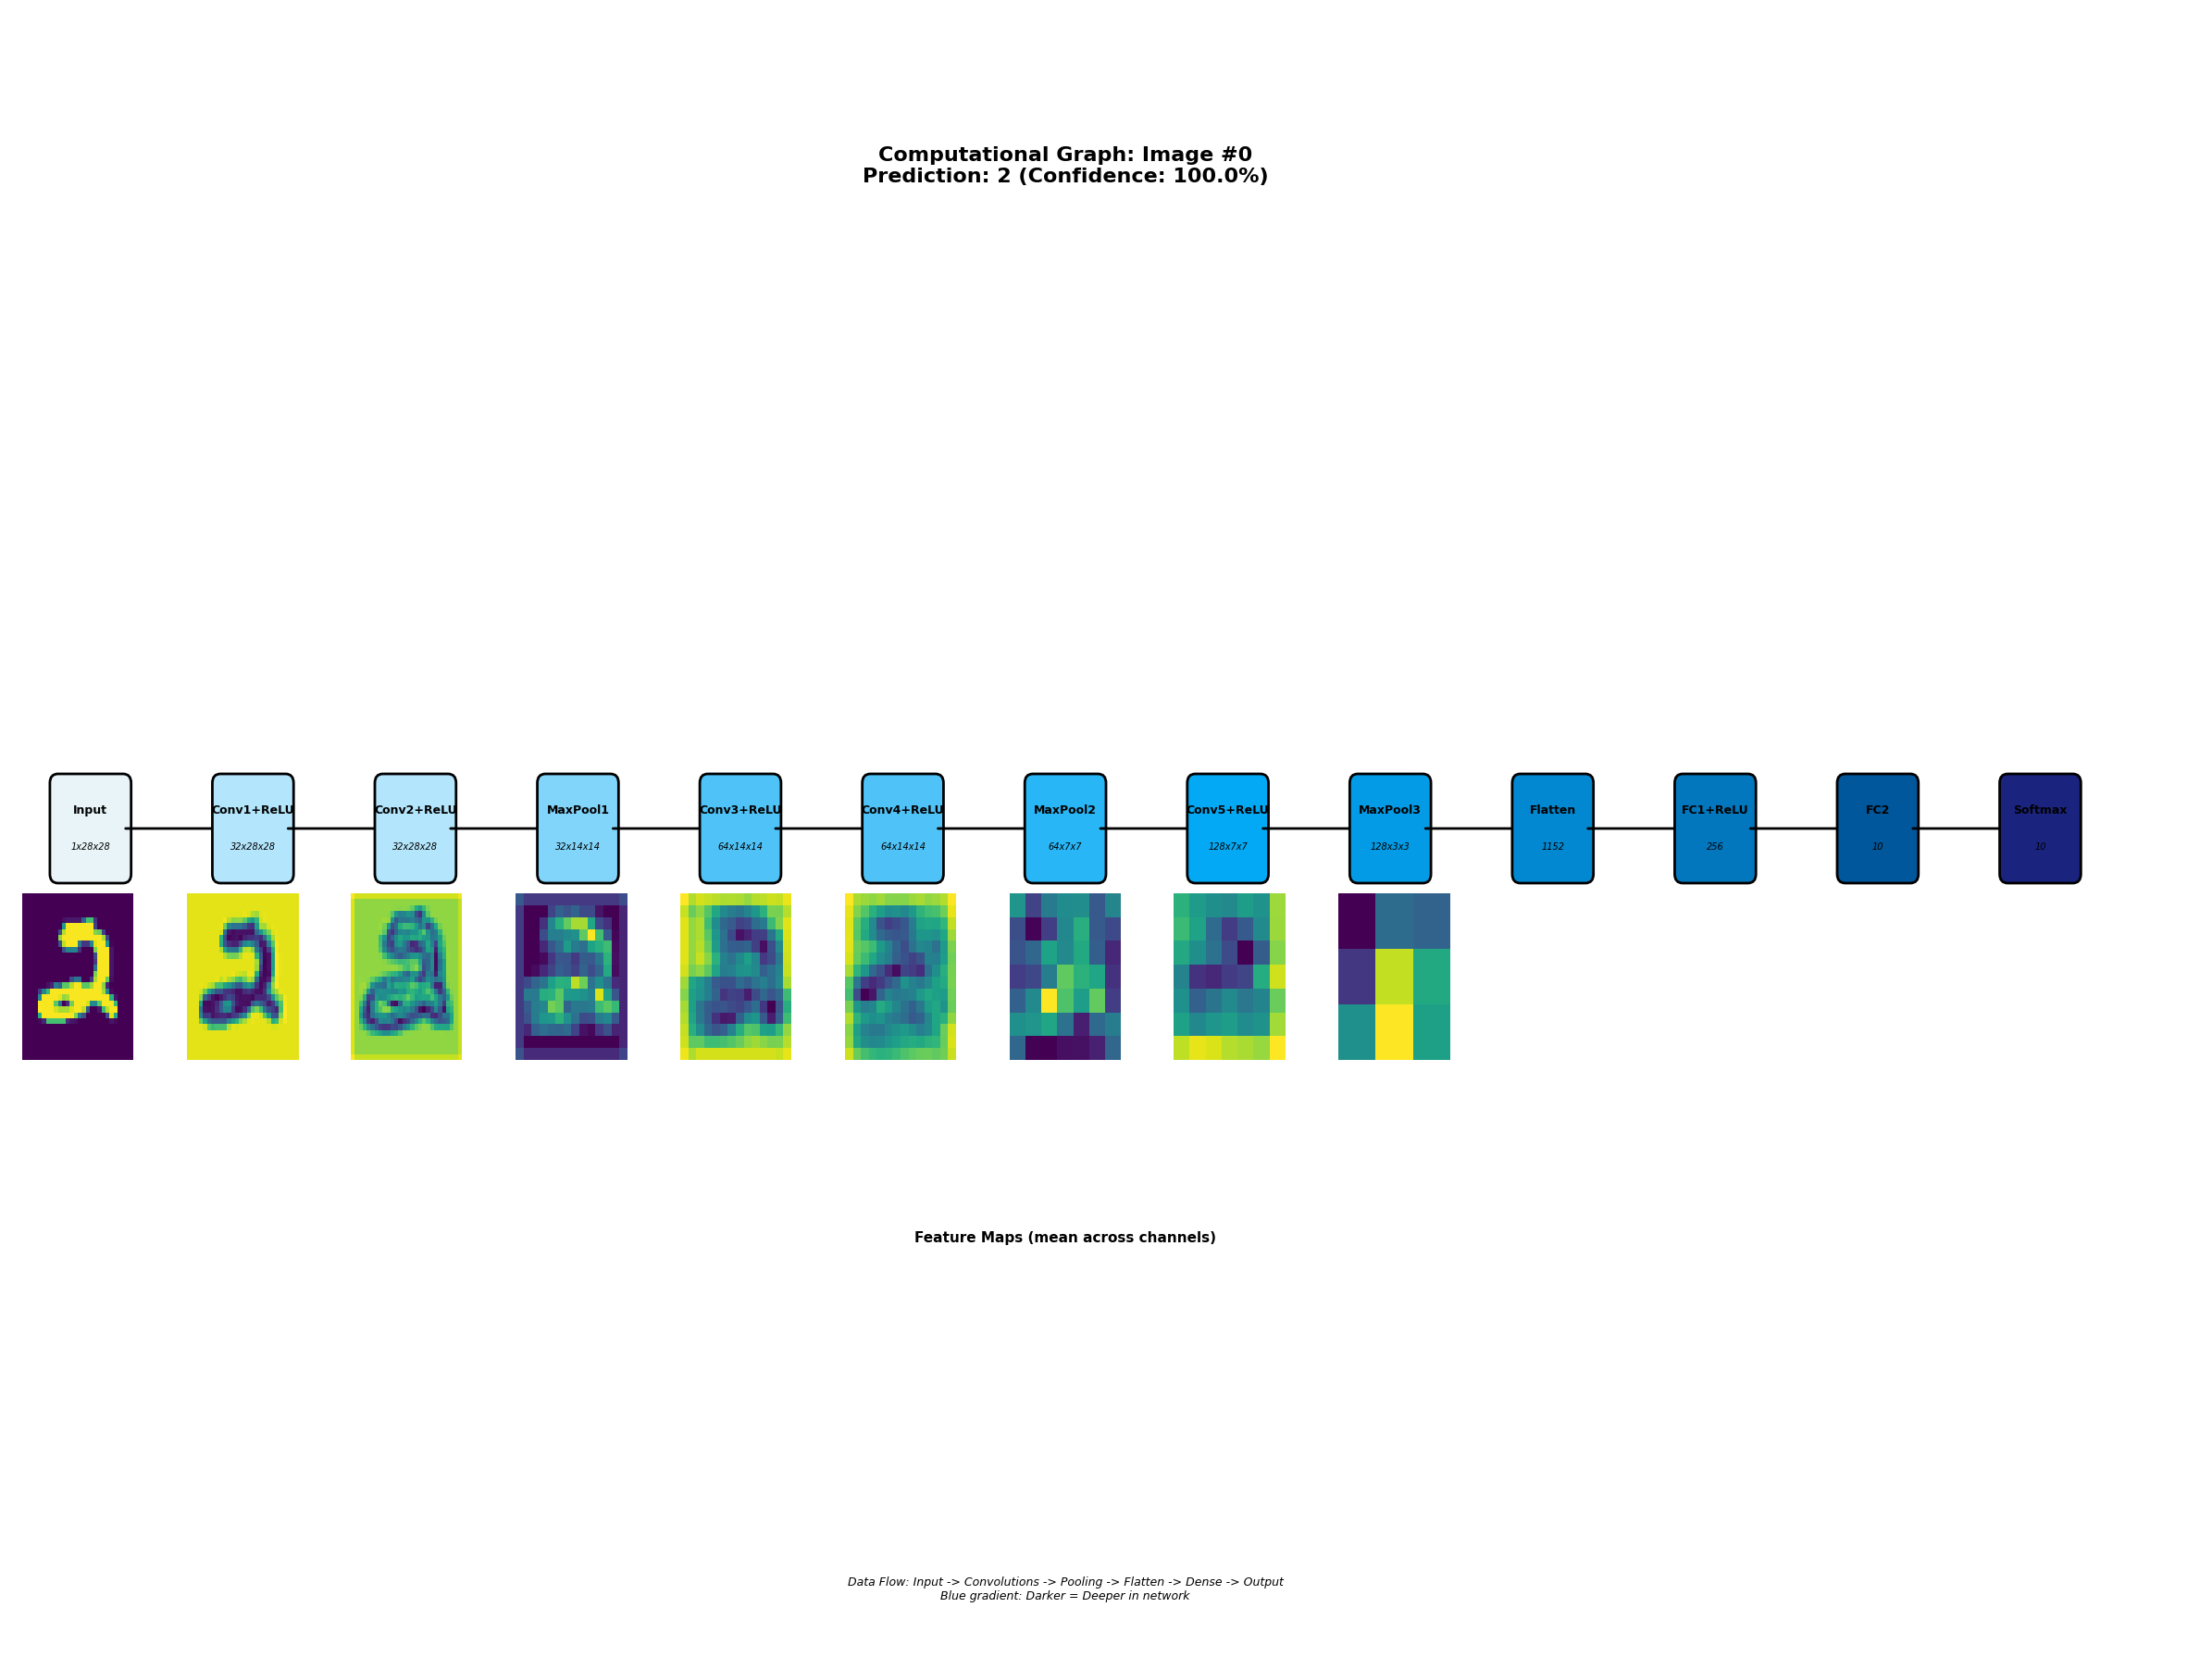

Prediction: 2 (Confidence: 100.00%)

Generating vertical flow visualization...


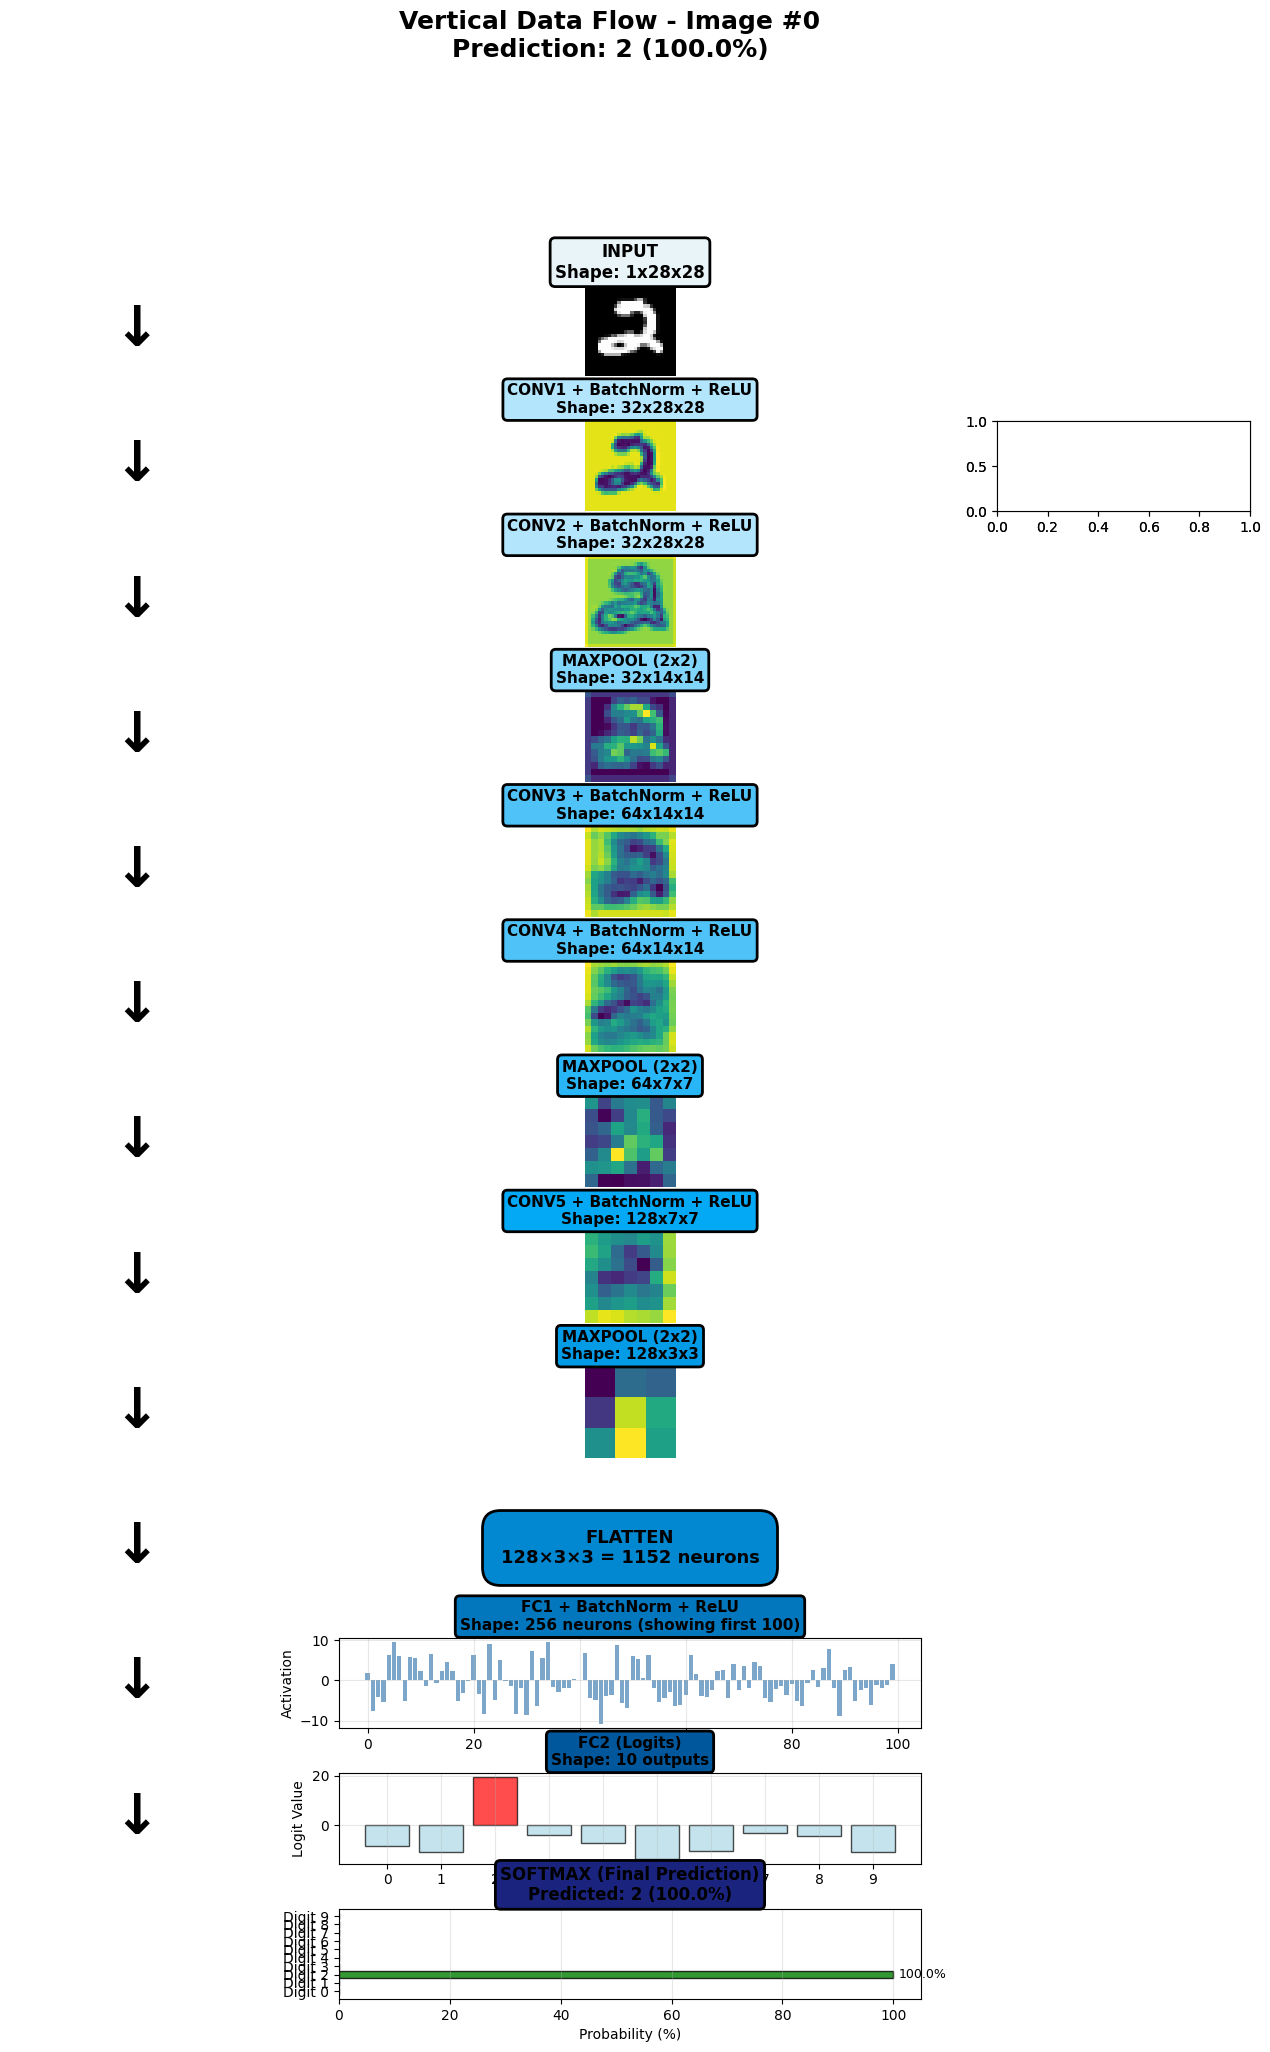

Prediction: 2 (Confidence: 100.00%)

Processing Image #100

Generating horizontal computational graph...


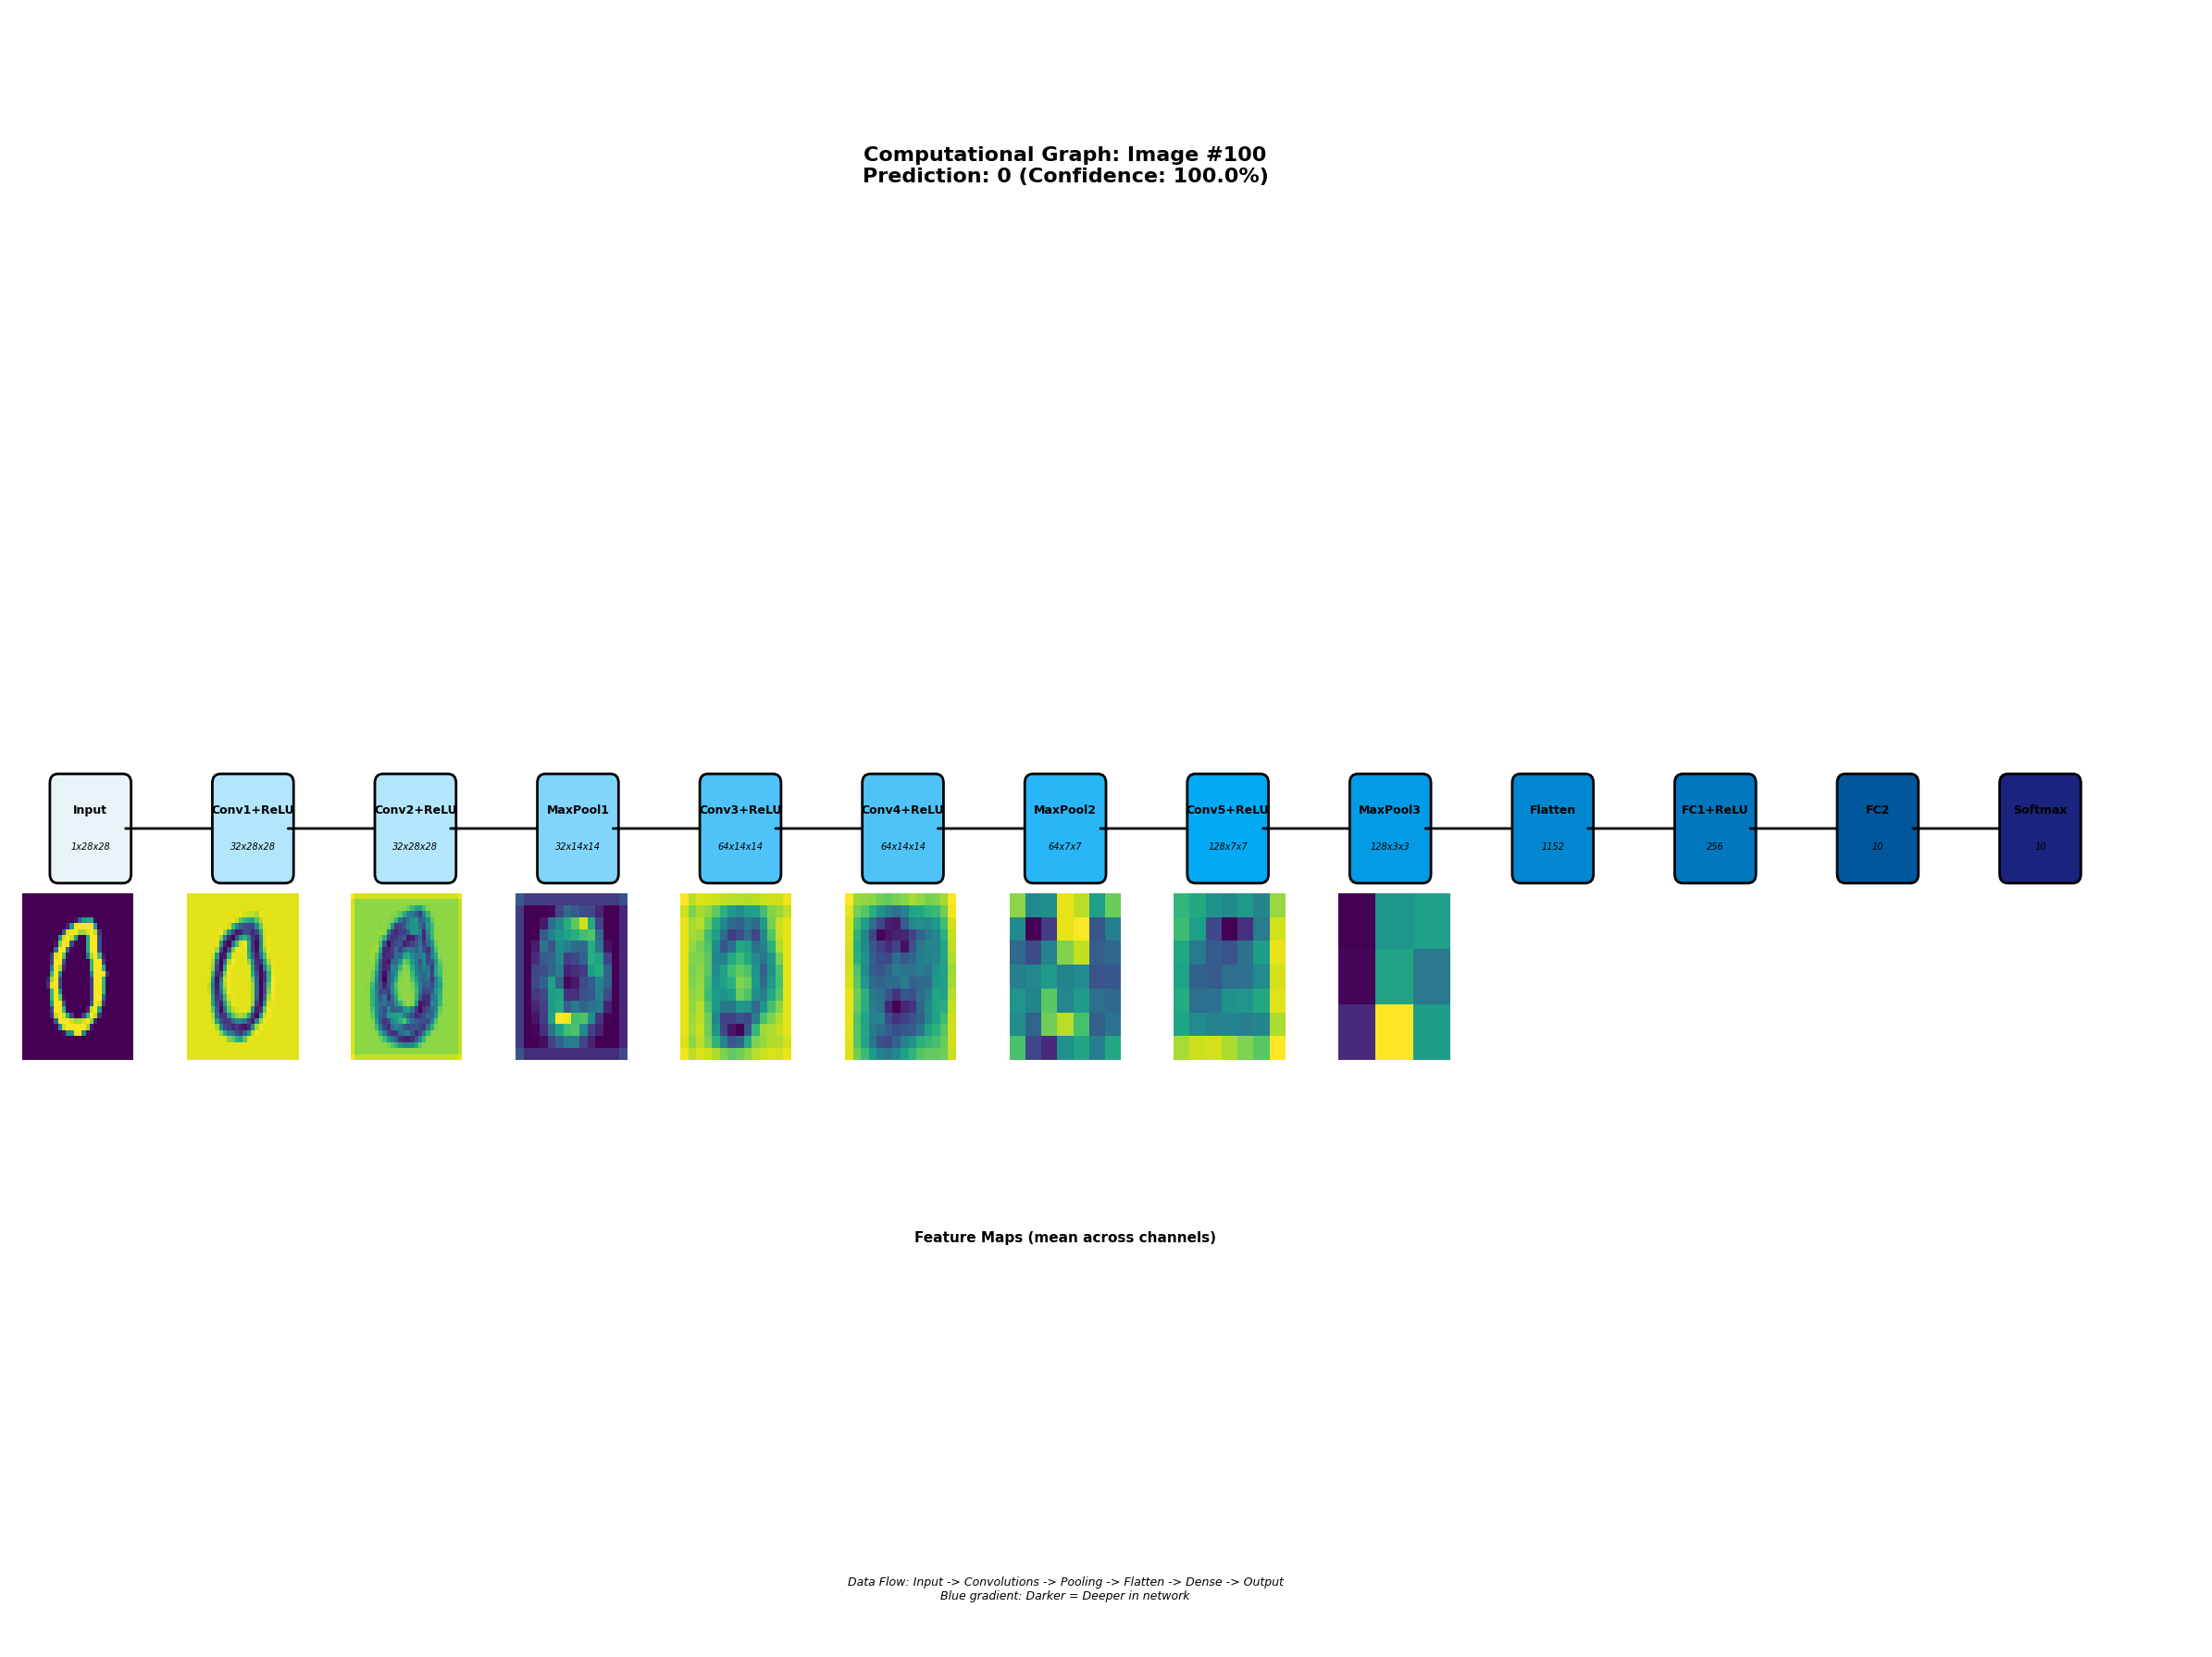

Prediction: 0 (Confidence: 100.00%)

Generating vertical flow visualization...


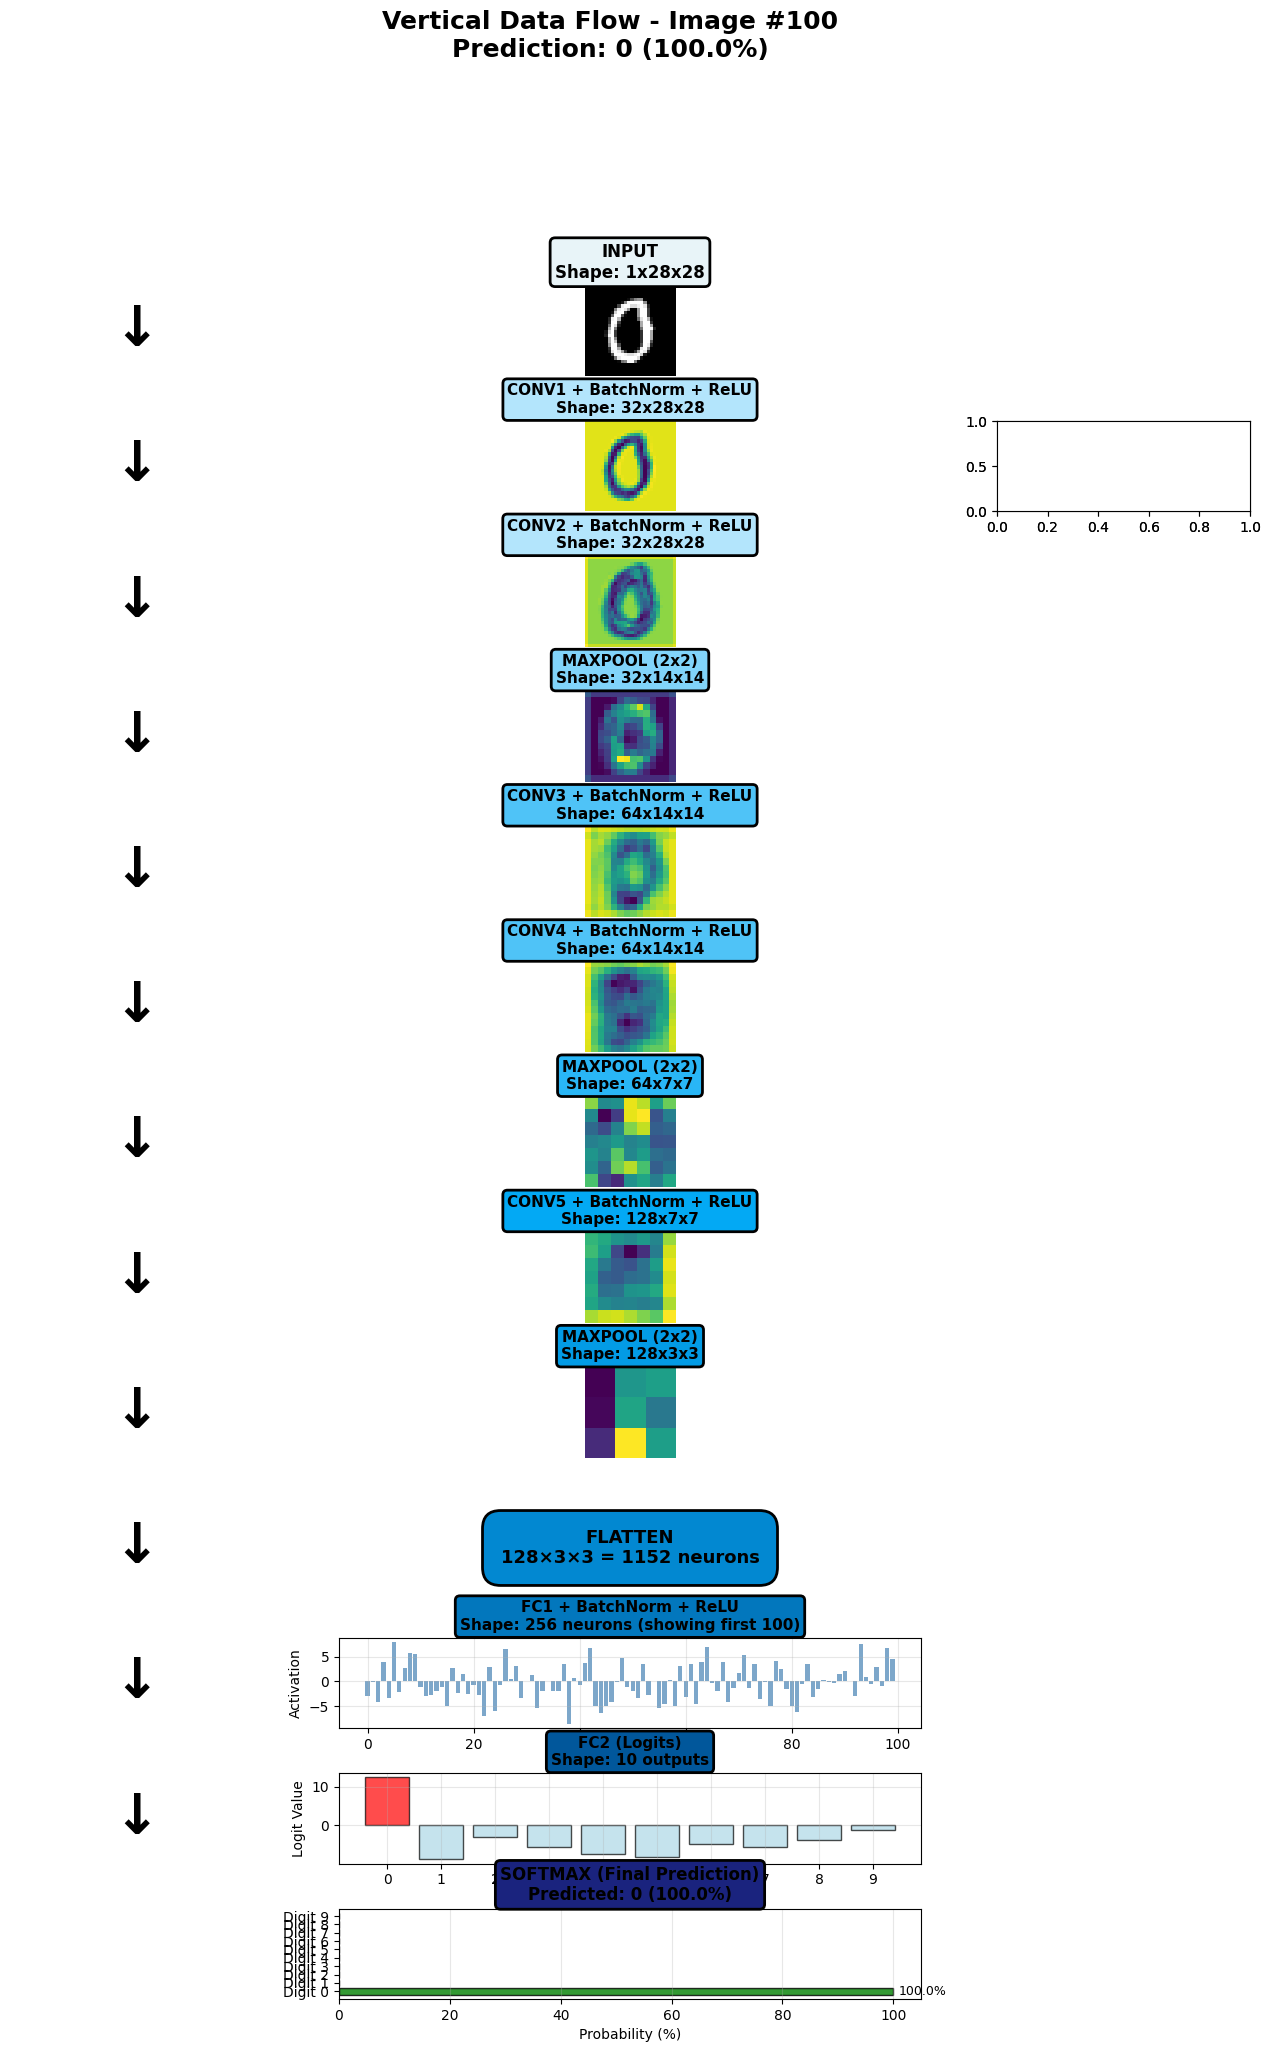

Prediction: 0 (Confidence: 100.00%)

Processing Image #500

Generating horizontal computational graph...


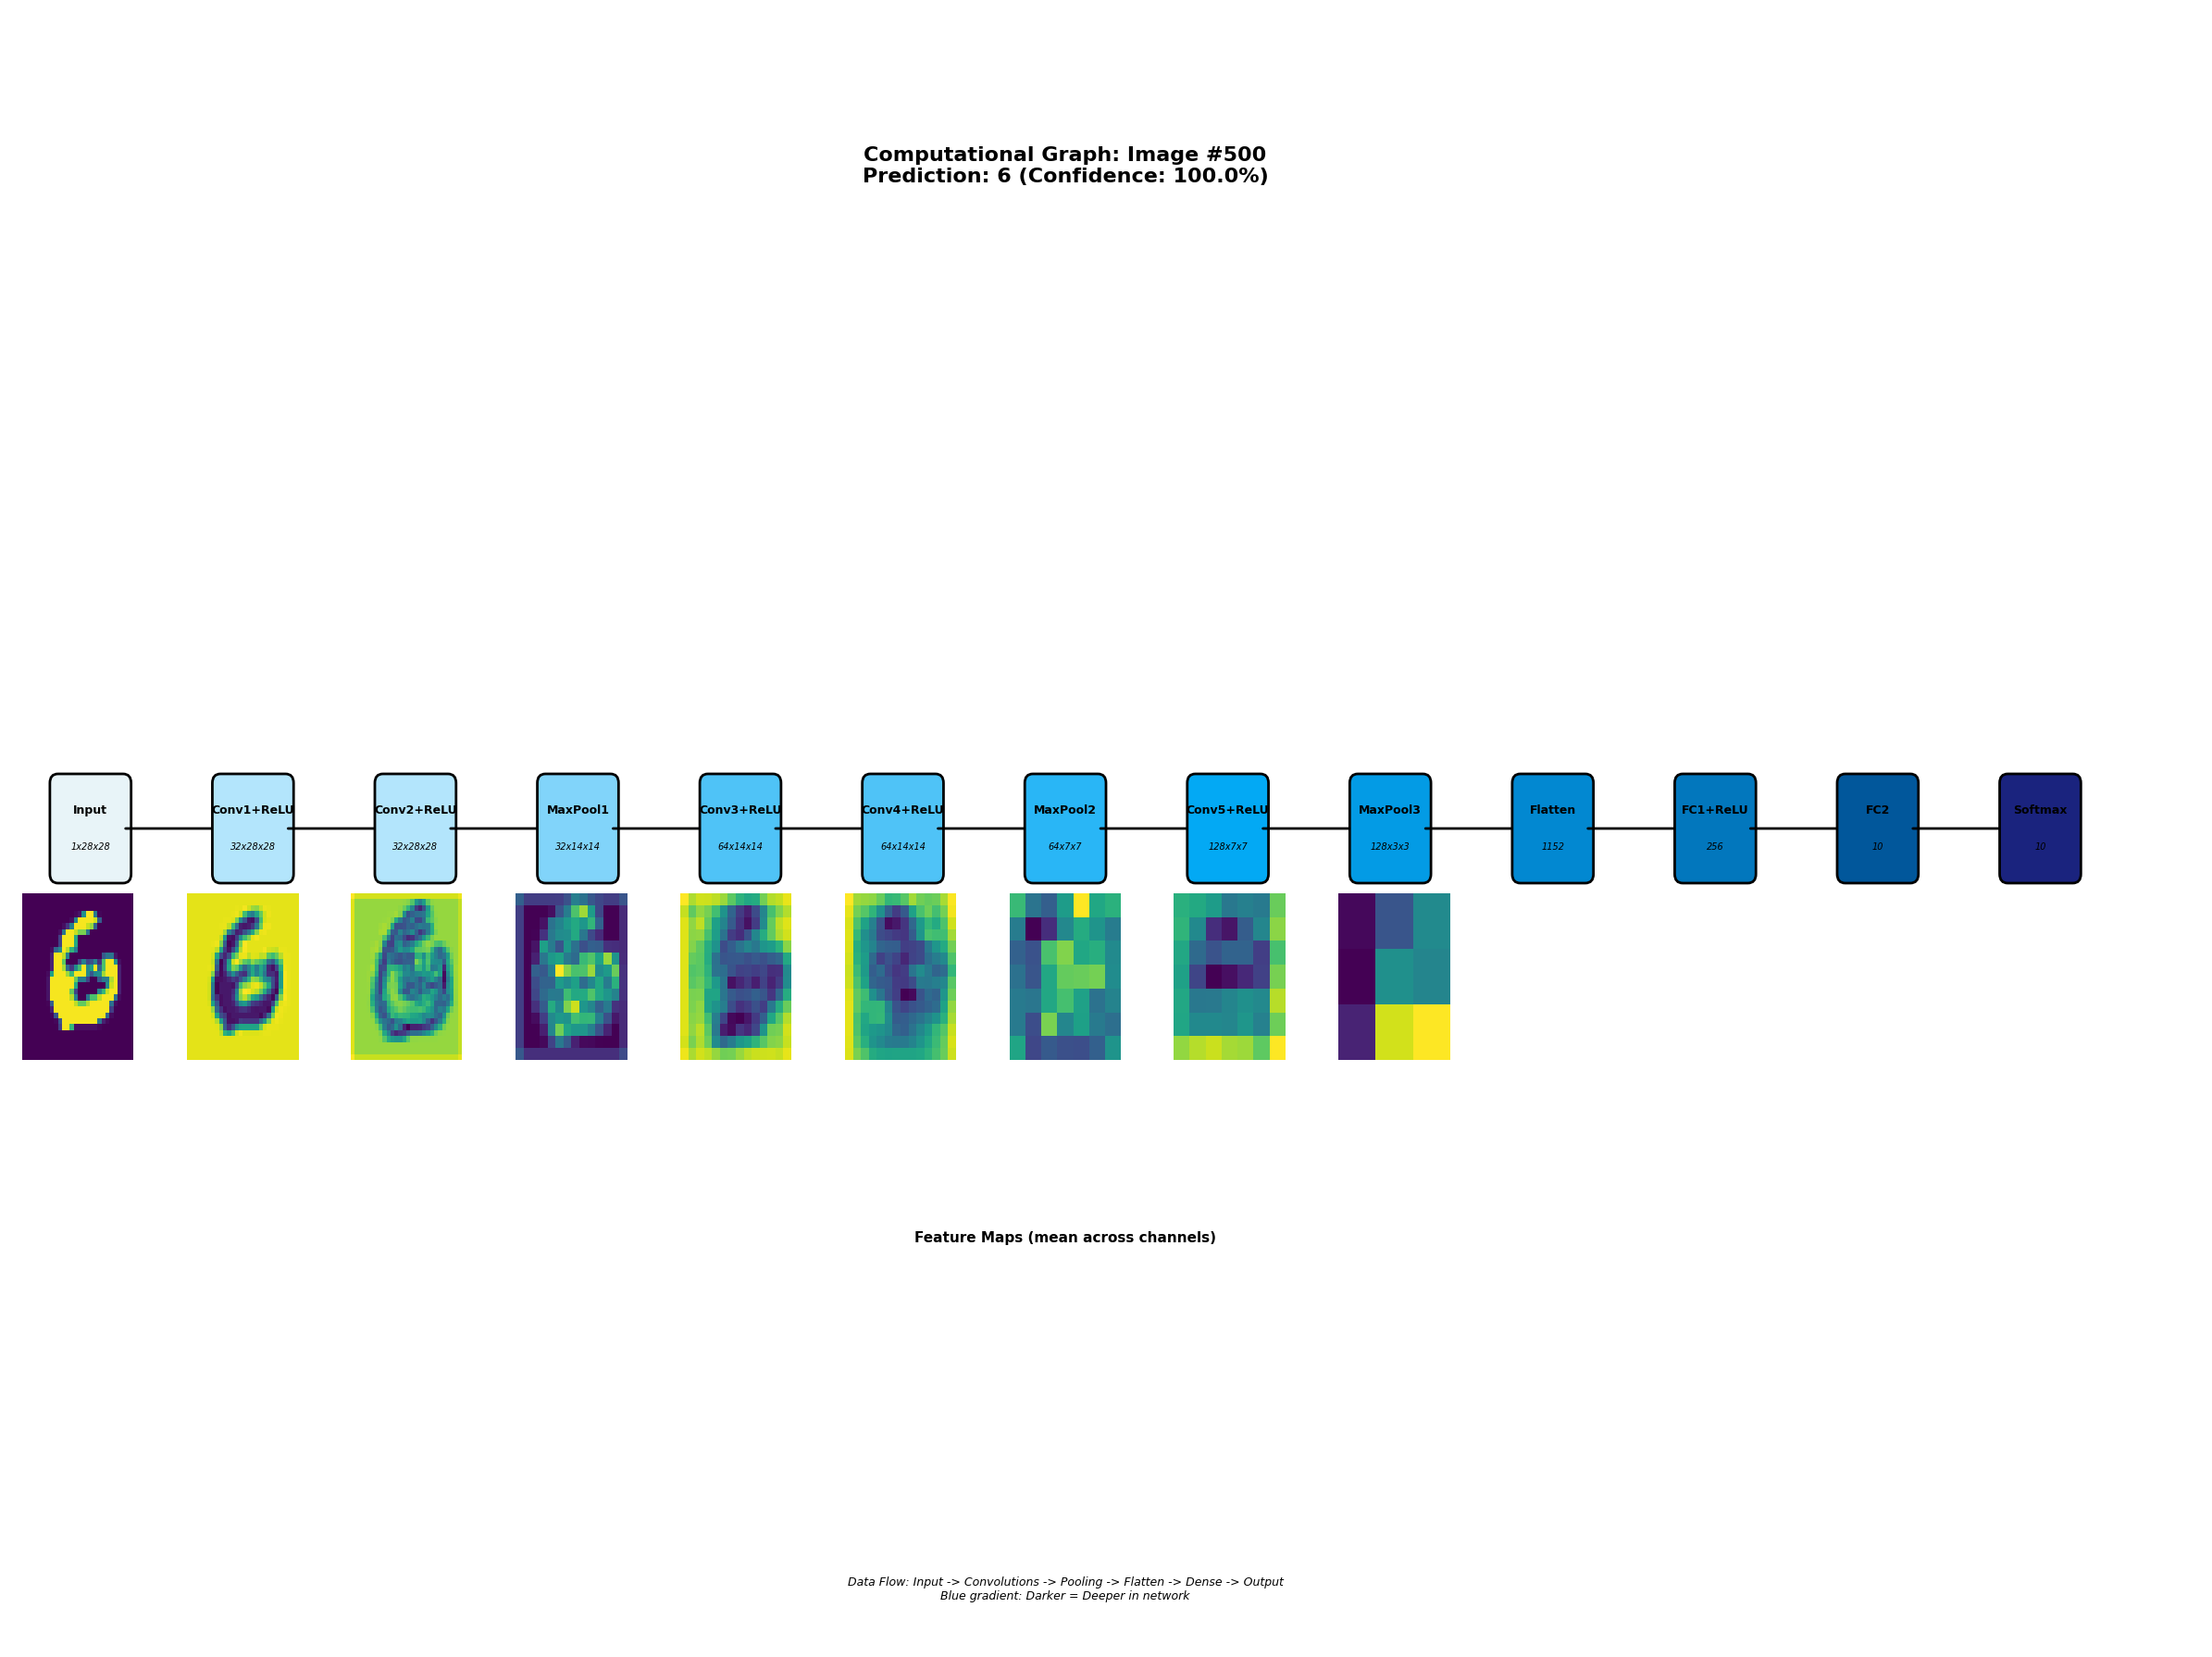

Prediction: 6 (Confidence: 100.00%)

Generating vertical flow visualization...


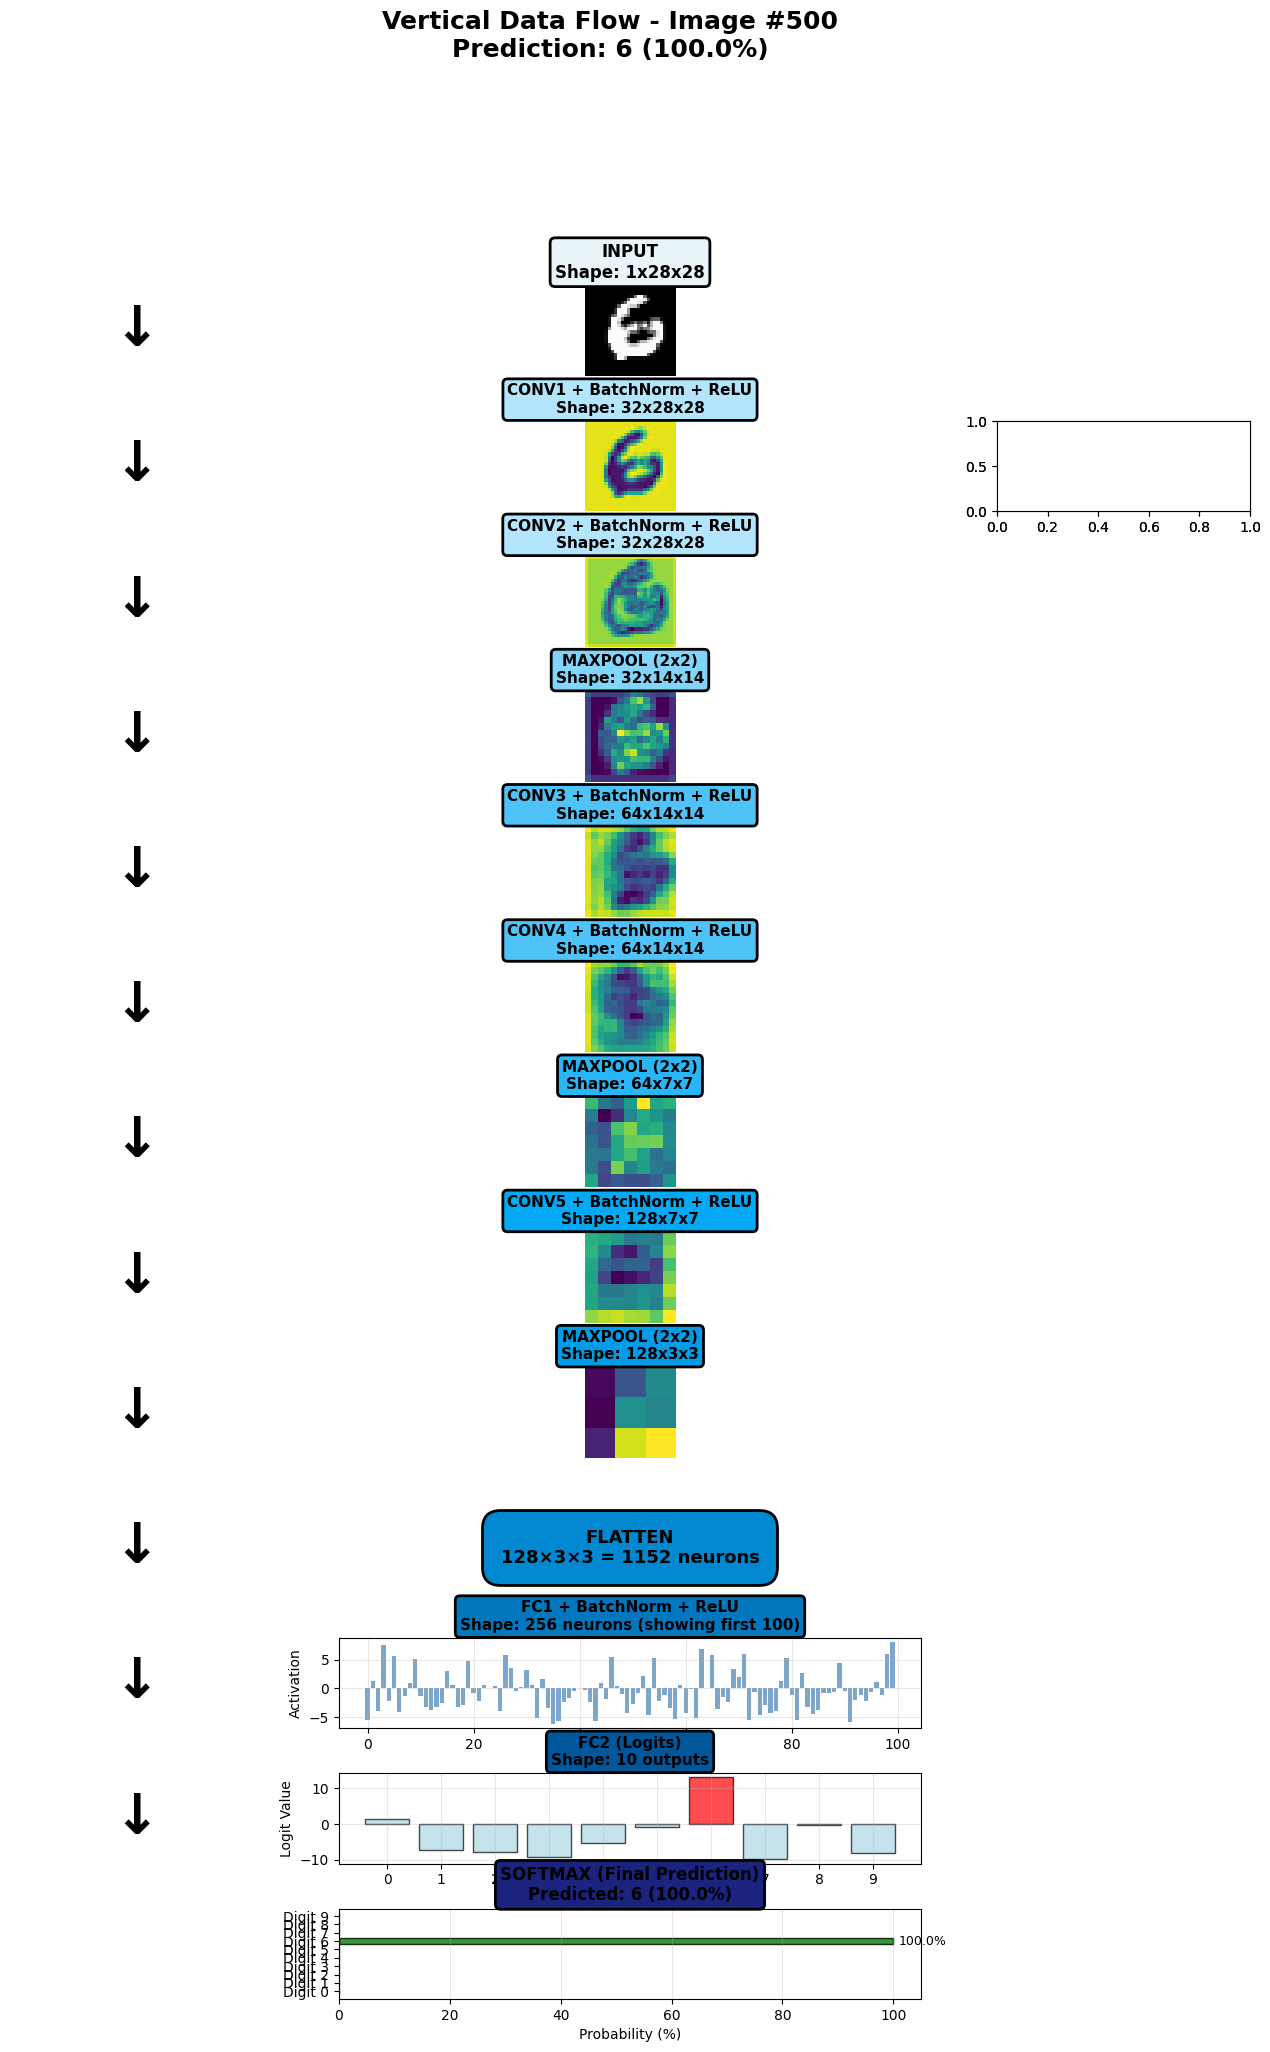

Prediction: 6 (Confidence: 100.00%)


All visualizations complete!
Saved to: graph_visualizations/


In [9]:
# Test on sample images
sample_indices = [0, 100, 500]

print("Generating computational graph visualizations...\n")

for idx in sample_indices:
    print(f"{'='*60}")
    print(f"Processing Image #{idx}")
    print(f"{'='*60}")
    
    image = test_dataset[idx]
    
    # Horizontal graph
    print("\nGenerating horizontal computational graph...")
    pred1, conf1 = visualize_computational_graph(model, image, idx, save=True)
    print(f"Prediction: {pred1} (Confidence: {conf1:.2f}%)")
    
    # Vertical flow
    print("\nGenerating vertical flow visualization...")
    pred2, conf2 = visualize_vertical_flow(model, image, idx, save=True)
    print(f"Prediction: {pred2} (Confidence: {conf2:.2f}%)")
    
    print()

print("\n" + "="*60)
print("All visualizations complete!")
print(f"Saved to: {CONFIG['output_dir']}")
print("="*60)

## 10. Summary

In [10]:
print("="*70)
print("COMPUTATIONAL GRAPH VISUALIZATION SUMMARY")
print("="*70)
print("\nThis notebook visualizes:")
print("\n1. Horizontal Computational Graph:")
print("   - All layers displayed horizontally")
print("   - Arrows show data flow")
print("   - Shape transformations at each node")
print("   - Feature map previews below each layer")
print("\n2. Vertical Flow Visualization:")
print("   - Detailed top-to-bottom flow")
print("   - Large feature map visualizations")
print("   - Layer-by-layer transformations")
print("   - Final prediction probabilities")
print("\nKey Features:")
print("   - Shows how image transforms through network")
print("   - Visualizes intermediate activations")
print("   - Displays shape changes at each layer")
print("   - Color-coded by depth (lighter -> darker)")
print("   - Final softmax probabilities")
print("\nOutput Files:")
print(f"   - {CONFIG['output_dir']}graph_imgX.png")
print(f"   - {CONFIG['output_dir']}vertical_flow_imgX.png")
print("="*70)

COMPUTATIONAL GRAPH VISUALIZATION SUMMARY

This notebook visualizes:

1. Horizontal Computational Graph:
   - All layers displayed horizontally
   - Arrows show data flow
   - Shape transformations at each node
   - Feature map previews below each layer

2. Vertical Flow Visualization:
   - Detailed top-to-bottom flow
   - Large feature map visualizations
   - Layer-by-layer transformations
   - Final prediction probabilities

Key Features:
   - Shows how image transforms through network
   - Visualizes intermediate activations
   - Displays shape changes at each layer
   - Color-coded by depth (lighter -> darker)
   - Final softmax probabilities

Output Files:
   - graph_visualizations/graph_imgX.png
   - graph_visualizations/vertical_flow_imgX.png
